# Linear Regression - predicting stock price

In [1]:
import pandas as pd
import quandl as qdl

# downloading the stock data
df = qdl.get('WIKI/GOOGL')

# taking just the useful data to create our feature vector.
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# transforming data to have more useful features
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0 #we may ignore 100
df['PCT_Change'] = (df['Adj. Open'] - df['Adj. Close']) / df['Adj. Close'] * 100.0

# creating final features
df = df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Adj. Volume']]

print(df.head())

            Adj. Close    HL_PCT  PCT_Change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017   -0.323915   44659000.0
2004-08-20   54.322689  8.537313   -6.739913   22834300.0
2004-08-23   54.869377  4.062357    1.243144   18256100.0
2004-08-24   52.597363  7.753210    6.074187   15247300.0
2004-08-25   53.164113  3.966115   -1.169811    9188600.0


In [2]:
import math
print('total data points: '+str(len(df)))

forecast_col = 'Adj. Close'

# filling in NA data points
df.fillna(-99999, inplace=True) #outlier in our dataset

forecast_out = int(math.ceil(0.01*len(df)))

# Creating lables which are the predictions.
# here, each row has lable col is Adj. close price
# forecast_out days in future.
df['label'] = df[forecast_col].shift(-forecast_out)

print('prediction is done for '
      + str(forecast_out)+ ' days \n')

print(df.head())

total data points: 3240
prediction is done for 33 days 

            Adj. Close    HL_PCT  PCT_Change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017   -0.323915   44659000.0  68.752232
2004-08-20   54.322689  8.537313   -6.739913   22834300.0  69.639972
2004-08-23   54.869377  4.062357    1.243144   18256100.0  69.078238
2004-08-24   52.597363  7.753210    6.074187   15247300.0  67.839414
2004-08-25   53.164113  3.966115   -1.169811    9188600.0  68.912727


In [3]:
import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle

'''
Creating input feature vectors by dropping the labels
'''
X = np.array(df.drop(['label'], 1))

'''
Scaling the input features
'''
X = preprocessing.scale(X)

'''
Creating input features to predict values.
'''
X_lately = X[-forecast_out:] # will use to predict against
X = X[:-forecast_out] # will use to train/test against

df.dropna(inplace=True)
y = np.array(df['label'])

print('training data input size='+str(len(X)),
      'and label size='+str(len(y)),
      ' should be equal')

# Splitting the dataset into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# creating Linear Regression model

clf = LinearRegression(n_jobs=-1)
#clf = svm.SVR(kernel='linear')

# training the model to fit the data set
clf.fit(X_train, y_train)

with open('1_linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
    
pickle_in = open('1_linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

# testing the accuracy of the trained model
accuracy = clf.score(X_test, y_test)

print('accuracy "Squared Error" of our trained model is '
      +str(accuracy) + '\n\n')

'''
Lets do some prediction
'''

predictions = clf.predict(X_lately)

print(predictions)

training data input size=3207 and label size=3207  should be equal
accuracy "Squared Error" of our trained model is 0.971080759071


[  981.68407667   956.39410647   966.75125633   971.40429487   981.02152621
   987.06801471   994.71342339  1008.06909198  1010.05847444  1013.37303863
  1002.54121496  1004.7041758   1013.09055172  1020.70334178  1012.76857213
  1018.66253478  1021.10067247   980.37629519   975.39080392   986.20807604
   983.09151391   975.74165277   974.65513747   991.86993196   985.05261833
   995.48996377   993.60308957  1002.89789421   986.56262267   962.60663255
   975.68988658   951.81138964   944.56004314]


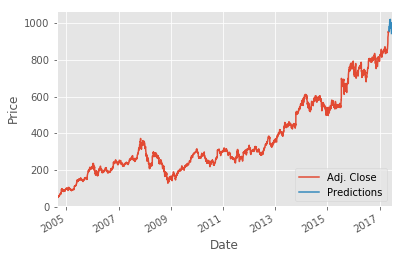

In [4]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df['Predictions'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for p in predictions:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [p]
    
    
df['Adj. Close'].plot()
df['Predictions'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()